In [80]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time
import pickle
from flask import Flask, request, jsonify
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier 
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

In [81]:
df = pd.read_csv('bank.csv')
print(df.head())

   age         job  marital  education default  balance housing loan  contact  \
0   59      admin.  married  secondary      no     2343     yes   no  unknown   
1   56      admin.  married  secondary      no       45      no   no  unknown   
2   41  technician  married  secondary      no     1270     yes   no  unknown   
3   55    services  married  secondary      no     2476     yes   no  unknown   
4   54      admin.  married   tertiary      no      184      no   no  unknown   

   day month  duration  campaign  pdays  previous poutcome deposit  
0    5   may      1042         1     -1         0  unknown     yes  
1    5   may      1467         1     -1         0  unknown     yes  
2    5   may      1389         1     -1         0  unknown     yes  
3    5   may       579         1     -1         0  unknown     yes  
4    5   may       673         2     -1         0  unknown     yes  


Text(0.5, 1.0, 'After Normalization')

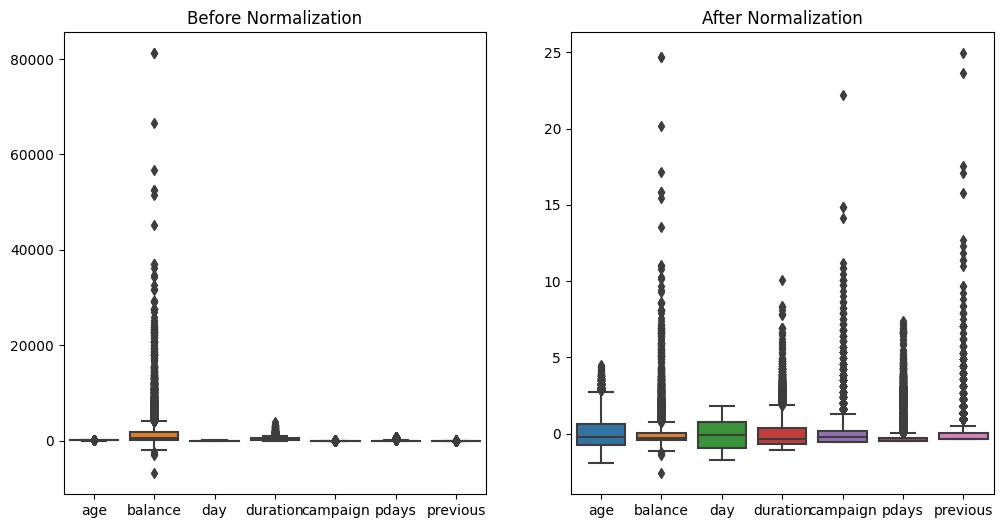

In [82]:
# Tar kontinuerliga features 
continuous_columns = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

#En ny dataframe innehållande koninuerliga features
continuous_df = df[continuous_columns]

# Normalisera den data som är kontinuerlig
scaler = StandardScaler()
normalized_data = scaler.fit_transform(continuous_df)

# En ny DataFrame från det normaliserade data
normalized_df = pd.DataFrame(normalized_data, columns=continuous_columns)

# BoxPlotgraf över innan och efter normalisering
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(data=continuous_df, ax=axes[0])
sns.boxplot(data=normalized_df, ax=axes[1])
axes[0].set_title('Before Normalization')
axes[1].set_title('After Normalization')

In [83]:
# Dessa features skall få ett numeriskt värde då dom inte har det från början.
categorical_columns = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'poutcome', 'deposit']
categorical_df = df[categorical_columns]

#Sedan läggs datan ihop i en df igen efter att en del av datan normaliserats
combined_df = pd.concat([normalized_df, categorical_df], axis=1)
le = LabelEncoder()

#Den data som är kategorisk gås här igenom och får ett numeriskt värde istället för texten innan. 
for column in categorical_columns:
    if not pd.api.types.is_numeric_dtype(combined_df[column]):
        combined_df[column] = le.fit_transform(combined_df[column])

# Visa de första 5 raderna av den kombinerade DataFrame
print(combined_df.head())

        age   balance       day  duration  campaign     pdays  previous  job  \
0  1.491505  0.252525 -1.265746  1.930226 -0.554168 -0.481184  -0.36326    0   
1  1.239676 -0.459974 -1.265746  3.154612 -0.554168 -0.481184  -0.36326    0   
2 -0.019470 -0.080160 -1.265746  2.929901 -0.554168 -0.481184  -0.36326    9   
3  1.155733  0.293762 -1.265746  0.596366 -0.554168 -0.481184  -0.36326    7   
4  1.071790 -0.416876 -1.265746  0.867171 -0.186785 -0.481184  -0.36326    0   

   marital  education  default  housing  loan  contact  month  poutcome  \
0        1          1        0        1     0        2      8         3   
1        1          1        0        0     0        2      8         3   
2        1          1        0        1     0        2      8         3   
3        1          1        0        1     0        2      8         3   
4        1          2        0        0     0        2      8         3   

   deposit  
0        1  
1        1  
2        1  
3        1  
4  

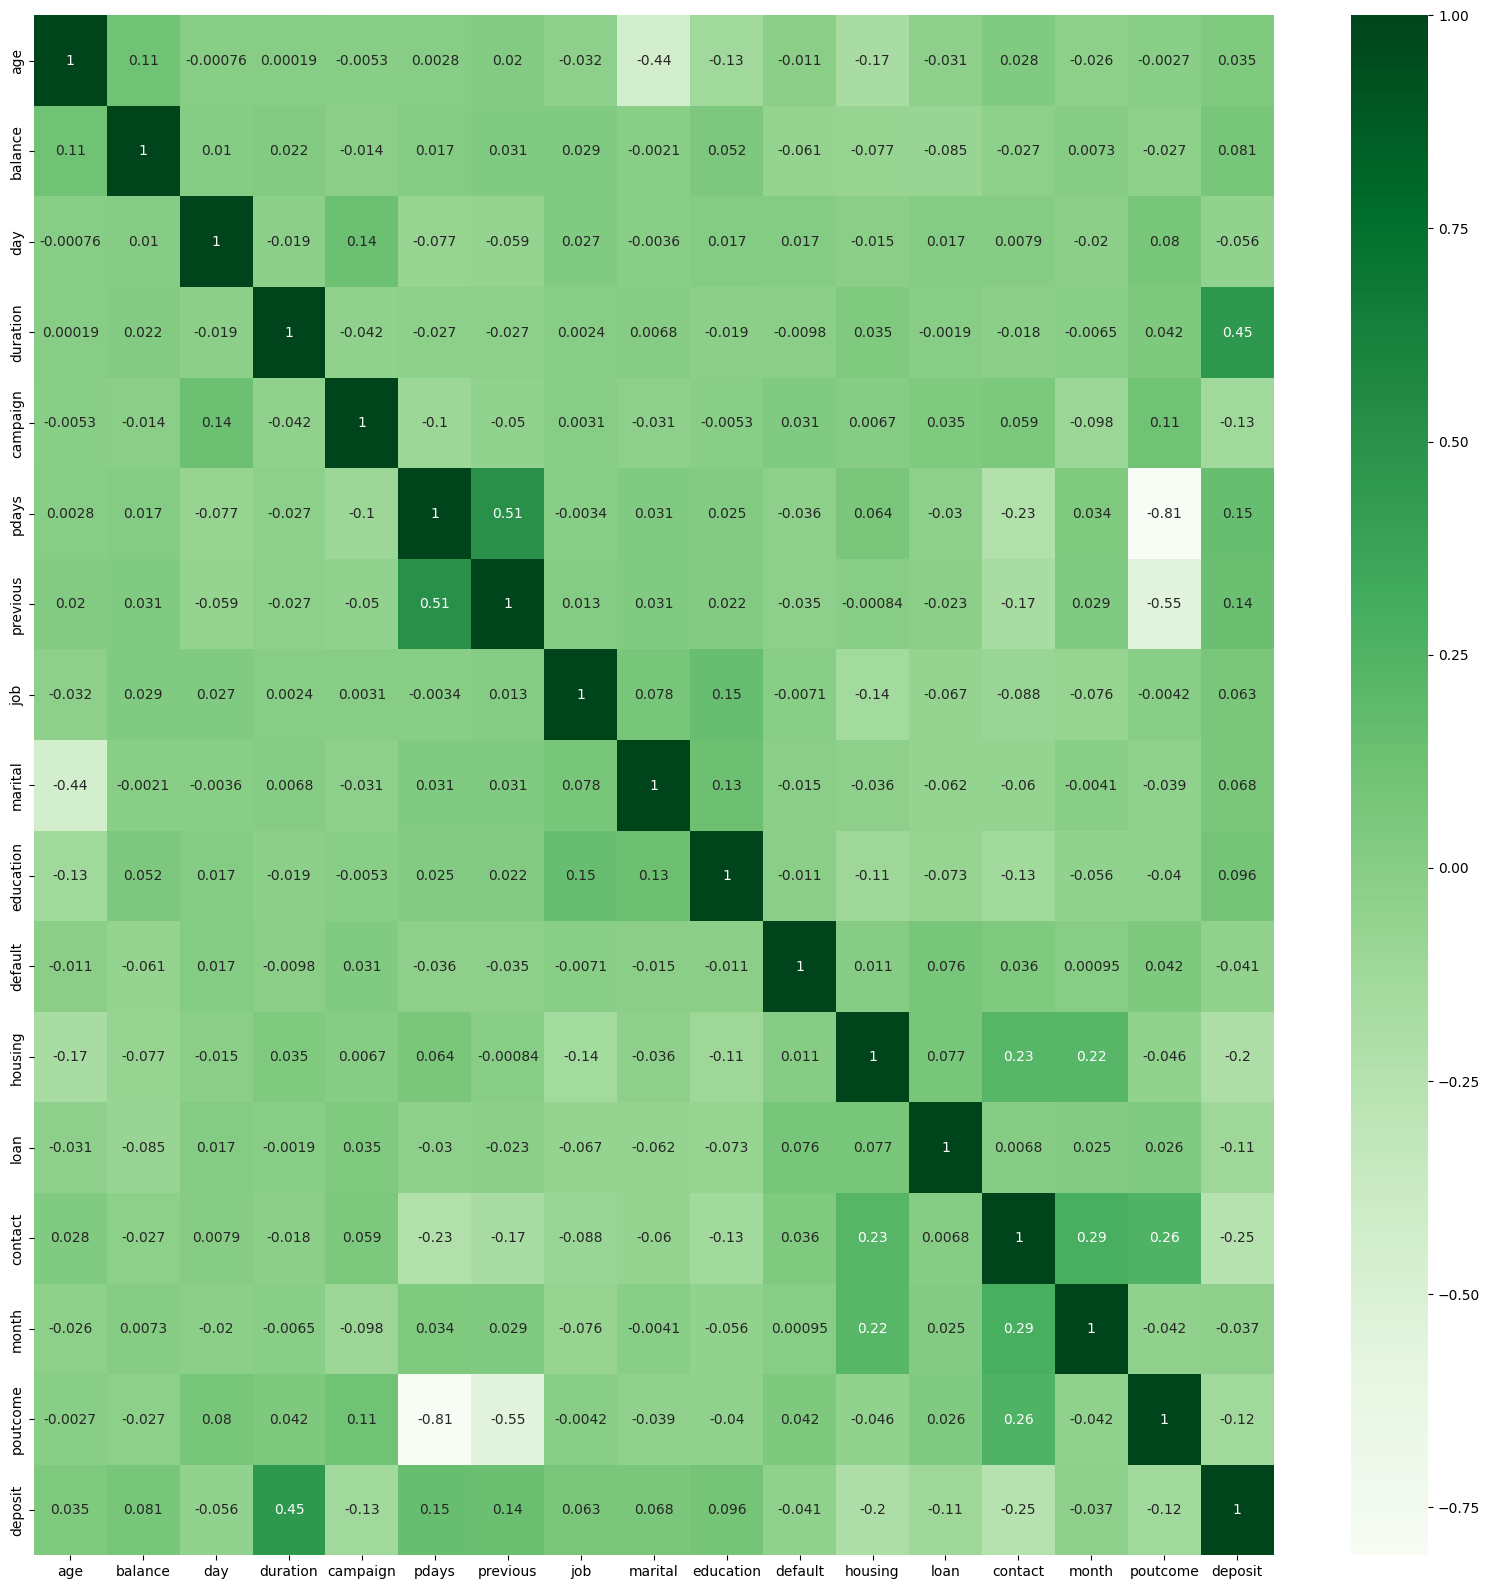

In [84]:
# Heatmap för att hitta intressanta korrelationer
plt.figure(figsize=(20,20))
sns.heatmap(combined_df.corr(), annot=True, cmap="Greens")
plt.show()

In [85]:
# Ta bort deposit från df
x = combined_df.drop("deposit", axis=1)
y = combined_df["deposit"]
# Dela upp data i test och träning
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

In [86]:
rfc = RandomForestClassifier(n_estimators=500)
start_time = time.time()
rfc.fit(x_train, y_train)

y_pred = rfc.predict(x_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
end_time = time.time()
total_time = end_time - start_time

print("Total tid: ", total_time, " sekunder")

Accuracy: 0.8414452075246343
Total tid:  4.985896825790405  sekunder


In [87]:
pickle.dump(rfc, open("model.pkl", "wb"))

In [ ]:
app = Flask(__name__)

model = pickle.load(open("model.pkl", "rb"))

@app.route("/bank", methods = ["POST"])
def send_data(): 
    json_ = request.json 
    query_df = pd.DataFrame(json_)
    prediction = model.predict(query_df)
    return jsonify({"Prediction": prediction.tolist()})

if __name__ == "__main__":
    app.run(debug=False)
    
%tb

 * Serving Flask app '__main__'
 * Debug mode: off


 * Running on http://127.0.0.1:5000
Press CTRL+C to quit
127.0.0.1 - - [30/Mar/2023 13:34:04] "POST /bank HTTP/1.1" 200 -
127.0.0.1 - - [30/Mar/2023 13:34:12] "POST /bank HTTP/1.1" 200 -


In [35]:
#Testa rfc med k-fold
rfc = RandomForestClassifier(n_estimators=500) 
start_time = time.time()
#gnb = GaussianNB()
#knn = KNeighborsClassifier(n_neighbors=5)
kf = KFold(n_splits=5, shuffle = True, random_state=42)

scores = cross_val_score(rfc,x,y,cv=kf, scoring="accuracy")
end_time = time.time()
total_time = end_time - start_time


print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
print("Total tid: ", total_time, " sekunder")

Accuracy: 0.85 (+/- 0.02)
Total tid:  28.56965923309326  sekunder


In [23]:
#Knn
knn = KNeighborsClassifier(n_neighbors=5)
start_time = time.time()
# Träna modellen på träningsdata
knn.fit(x_train, y_train)

# Gör prediction på testdata
y_pred = knn.predict(x_test)

# Få fram accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
end_time = time.time()
total_time = end_time - start_time

print("Total tid: ", total_time, " sekunder")

Accuracy: 0.7966557181248134
Total tid:  0.11498498916625977  sekunder


In [24]:
#naive bayes Gaussian/ kontinuerlig numerisk data
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()
start_time = time.time()
# Träna modellen på träningsdata
gnb.fit(x_train, y_train)

# Gör prediction på testdata
y_pred = gnb.predict(x_test)

# Få fram accuracy
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy) 
end_time = time.time()
total_time = end_time - start_time

print("Total tid: ", total_time, " sekunder")

Accuracy: 0.7446999104210212
Total tid:  0.008296489715576172  sekunder
